In [ ]:
!gdown --id 1HdqA8yWVxZ8od0hngKzZTziHx_ONzCWj

Downloading...
From: https://drive.google.com/uc?id=1HdqA8yWVxZ8od0hngKzZTziHx_ONzCWj
To: /content/instance-level_human_parsing.tar.gz
2.03GB [00:22, 89.7MB/s]


In [ ]:
!tar -xvf /content/instance-level_human_parsing.tar.gz

Streaming output truncated to the last 5000 lines.
instance-level_human_parsing/Testing/Images/0037573.jpg
instance-level_human_parsing/Testing/Images/0033068.jpg
instance-level_human_parsing/Testing/Images/0035298.jpg
instance-level_human_parsing/Testing/Images/0002339.jpg
instance-level_human_parsing/Testing/Images/0017562.jpg
instance-level_human_parsing/Testing/Images/0037435.jpg
instance-level_human_parsing/Testing/Images/0004422.jpg
instance-level_human_parsing/Testing/Images/0011872.jpg
instance-level_human_parsing/Testing/Images/0007900.jpg
instance-level_human_parsing/Testing/Images/0015033.jpg
instance-level_human_parsing/Testing/Images/0036605.jpg
instance-level_human_parsing/Testing/Images/0028815.jpg
instance-level_human_parsing/Testing/Images/0020045.jpg
instance-level_human_parsing/Testing/Images/0037771.jpg
instance-level_human_parsing/Testing/Images/0033402.jpg
instance-level_human_parsing/Testing/Images/0036409.jpg
instance-level_human_parsing/Testing/Images/0026903.j

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from glob import glob

In [ ]:
img_w, img_h = 512, 512
batch_size = 4
num_classes = 20

In [ ]:
def read_img(image_path,mask=False):
    img = tf.io.read_file(image_path)
    if mask:
      img = tf.image.decode_png(img, channels=1)
      img.set_shape([None, None, 1])
      img = (tf.image.resize(images=img, size=[
                    img_h, img_w]))
      img = tf.cast(img,tf.float32)
    else:
      img = tf.image.decode_png(img, channels=3)
      img.set_shape([None, None, 3])
      img = (tf.image.resize(images=img, size=[
                    img_h, img_w]))
      img = tf.cast(img,tf.float32) / 127.5 - 1
    return img

def load_data(img_list,mask_list):
  img = read_img(img_list)
  mask = read_img(mask_list,mask=True)
  return img, mask

In [ ]:
def data_generator(img_list,mask_list):
  dataset = tf.data.Dataset.from_tensor_slices((img_list,
                                                    mask_list))
  dataset = dataset.map(load_data,num_parallel_calls=
                        tf.data.experimental.AUTOTUNE)
  dataset = dataset.batch(batch_size,drop_remainder=True)
  dataset = dataset.repeat()
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

train_images_folder = sorted(glob('/content/instance-level_human_parsing/Training/Images/*'))
train_mask_folder = sorted(glob('/content/instance-level_human_parsing/Training/Category_ids/*'))
valid_images_folder = sorted(glob('/content/instance-level_human_parsing/Validation/Images/*'))
valid_mask_folder = sorted(glob('/content/instance-level_human_parsing/Validation/Category_ids/*'))

train_dataset = data_generator(train_images_folder,train_mask_folder)
valid_dataset = data_generator(valid_images_folder,valid_mask_folder)

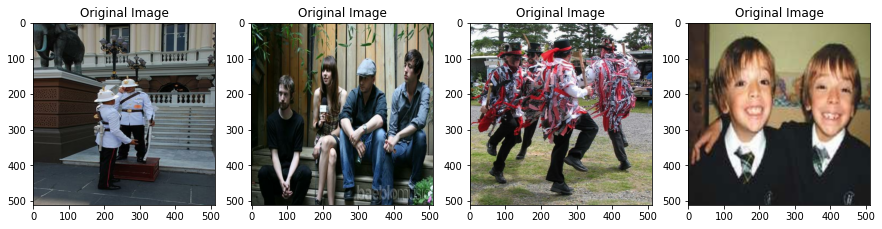

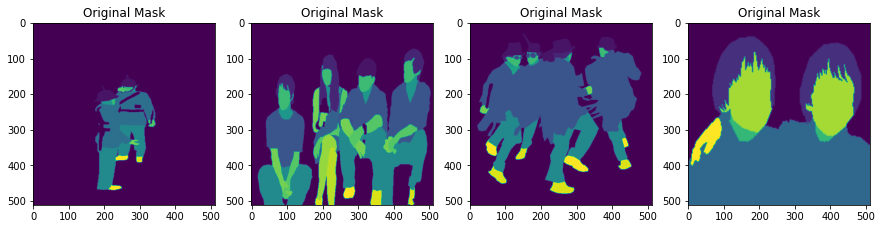

In [ ]:
def show_train(dataset):
 plt.figure(figsize=(15,15))
 for i in range(batch_size):
    for val in dataset.take(1):
      img = tf.cast((val[0][i]+1)*127.5,tf.uint8)
      plt.subplot(1,4,i+1)
      plt.imshow(img)
      plt.title("Original Image")
 plt.show()
 
 plt.figure(figsize=(15,15))
 for i in range(batch_size):
    for val in dataset.take(1):
      plt.subplot(1,4,i+1)
      plt.imshow(tf.squeeze(val[1][i]))
      plt.title("Original Mask")
plt.show()
 
show_train(train_dataset)

In [ ]:
def AtrousSpatialPyramidPooling(model_input):
  dims = tf.keras.backend.int_shape(model_input)

  layer = tf.keras.layers.AveragePooling2D(pool_size=(dims[-3],
                                                      dims[-2]))(model_input)
  layer = tf.keras.layers.Conv2D(256, kernel_size=1, padding='same',
                                 kernel_initializer = 'he_normal')(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  out_pool = tf.keras.layers.UpSampling2D(size = (dims[-3] // layer.shape[1],
                                               dims[-2] // layer.shape[2]),
                                        interpolation = 'bilinear')(layer)
  
  layer = tf.keras.layers.Conv2D(256, kernel_size = 1,
                                   dilation_rate = 1, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_1 = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 6, padding = 'same', 
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_6 = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 12, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_12 = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   dilation_rate = 18, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(model_input)
  layer = tf.keras.layers.BatchNormalization()(layer)
  out_18 = tf.keras.layers.ReLU()(layer)

  layer = tf.keras.layers.Concatenate(axis = -1)([out_pool, out_1,
                                                    out_6, out_12,
                                                    out_18])

  layer = tf.keras.layers.Conv2D(256, kernel_size = 1,
                                   dilation_rate = 1, padding = 'same',
                                   kernel_initializer = 'he_normal',
                                   use_bias = False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  model_output = tf.keras.layers.ReLU()(layer)
  return model_output


In [ ]:
def DeeplabV3Plus(nclasses = 20):
  model_input = tf.keras.Input(shape=(img_h,img_w,3))
  resnet50 = tf.keras.applications.ResNet50(weights = 'imagenet',
                                            include_top = False,
                                            input_tensor = model_input)
  layer = resnet50.get_layer('conv4_block6_2_relu').output
  layer = AtrousSpatialPyramidPooling(layer)
  input_a = tf.keras.layers.UpSampling2D(size = (img_h // 4 // layer.shape[1],
                                                 img_w // 4 // layer.shape[2]),
                                          interpolation = 'bilinear')(layer)

  input_b = resnet50.get_layer('conv2_block3_2_relu').output
  input_b = tf.keras.layers.Conv2D(48, kernel_size = (1,1), padding = 'same',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(input_b)
  input_b = tf.keras.layers.BatchNormalization()(input_b)
  input_b = tf.keras.layers.ReLU()(input_b)

  layer = tf.keras.layers.Concatenate(axis = -1)([input_a, input_b])

  layer = tf.keras.layers.Conv2D(256, kernel_size = 3,
                                   padding = 'same', activation = 'relu',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.Conv2D(256, kernel_size =3,
                                   padding = 'same', activation = 'relu',
                                   kernel_initializer = tf.keras.initializers.he_normal(),
                                   use_bias = False)(layer)
  layer = tf.keras.layers.BatchNormalization()(layer)
  layer = tf.keras.layers.ReLU()(layer)
  layer = tf.keras.layers.UpSampling2D(size = (img_h // layer.shape[1],
                                                 img_w // layer.shape[2]),
                                          interpolation = 'bilinear')(layer)
  model_output = tf.keras.layers.Conv2D(num_classes, kernel_size = (1,1),
                                   padding = 'same')(layer)
  return tf.keras.Model(inputs = model_input, outputs = model_output)

model = DeeplabV3Plus()
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

94773248/94765736 [==============================] - 3s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
epochs=25
step_per_epoch=len(train_images_folder)//batch_size
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss,metrics=['accuracy'])
filepath = '/content/deeplab_model.h5'
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='loss',
                                                save_best_only=True,
                                                mode='min')

model.fit(train_dataset,steps_per_epoch=step_per_epoch, epochs=epochs,
          validation_data=valid_dataset,
          validation_steps=len(valid_images_folder)//batch_size, 
          callbacks=[checkpoint])

Epoch 1/25
7070/7070 [==============================] - 6643s 940ms/step - loss: 0.7217 - accuracy: 0.7707 - val_loss: 0.6750 - val_accuracy: 0.7890
Epoch 2/25
7070/7070 [==============================] - 6632s 938ms/step - loss: 0.5674 - accuracy: 0.8164 - val_loss: 0.5632 - val_accuracy: 0.8215
Epoch 3/25
7070/7070 [==============================] - 6626s 937ms/step - loss: 0.5027 - accuracy: 0.8372 - val_loss: 0.5370 - val_accuracy: 0.8305
Epoch 4/25
7070/7070 [==============================] - 6624s 937ms/step - loss: 0.4568 - accuracy: 0.8524 - val_loss: 0.5336 - val_accuracy: 0.8361
Epoch 5/25
7070/7070 [==============================] - 6619s 936ms/step - loss: 0.4201 - accuracy: 0.8650 - val_loss: 0.5360 - val_accuracy: 0.8385
Epoch 6/25
3283/7070 [============>.................] - ETA: 55:54 - loss: 0.4262 - accuracy: 0.8625

In [ ]:
epochs=21
step_per_epoch=len(train_images_folder)//batch_size
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss,metrics=['accuracy'])

filepath = '/content/deeplab_model.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='loss',
                                                save_best_only=True,
                                                mode='min')

model.load_weights(filepath)

model.fit(train_dataset,steps_per_epoch=step_per_epoch, epochs=epochs,
          validation_data=valid_dataset,
          validation_steps=len(valid_images_folder)//batch_size, 
          callbacks=[checkpoint])

Epoch 1/21
7070/7070 [==============================] - 3029s 428ms/step - loss: 0.4192 - accuracy: 0.8653 - val_loss: 0.5447 - val_accuracy: 0.8359
Epoch 2/21
7070/7070 [==============================] - 3028s 428ms/step - loss: 0.3925 - accuracy: 0.8743 - val_loss: 0.5381 - val_accuracy: 0.8371
Epoch 3/21
7070/7070 [==============================] - 3025s 428ms/step - loss: 0.3702 - accuracy: 0.8818 - val_loss: 0.5259 - val_accuracy: 0.8430
Epoch 4/21
7070/7070 [==============================] - 3024s 428ms/step - loss: 0.3500 - accuracy: 0.8887 - val_loss: 0.5274 - val_accuracy: 0.8412
Epoch 5/21
7070/7070 [==============================] - 3021s 427ms/step - loss: 0.3344 - accuracy: 0.8937 - val_loss: 0.5241 - val_accuracy: 0.8456
Epoch 6/21
7070/7070 [==============================] - 3023s 428ms/step - loss: 0.3193 - accuracy: 0.8987 - val_loss: 0.5523 - val_accuracy: 0.8430
Epoch 7/21
7070/7070 [==============================] - 3025s 428ms/step - loss: 0.3053 - accuracy: 0.9035

In [ ]:
epochs=7
step_per_epoch=len(train_images_folder)//batch_size
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=loss,metrics=['accuracy'])

filepath = '/content/deeplab_model 18.h5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath,
                                                monitor='loss',
                                                save_best_only=True,
                                                mode='min')

model.load_weights(filepath)

model.fit(train_dataset,steps_per_epoch=step_per_epoch, epochs=epochs,
          validation_data=valid_dataset,
          validation_steps=len(valid_images_folder)//batch_size, 
          callbacks=[checkpoint])

Epoch 1/7
7070/7070 [==============================] - 6755s 955ms/step - loss: 0.2379 - accuracy: 0.9257 - val_loss: 0.5985 - val_accuracy: 0.8458
Epoch 2/7
4133/7070 [================>.............] - ETA: 43:51 - loss: 0.2444 - accuracy: 0.9237

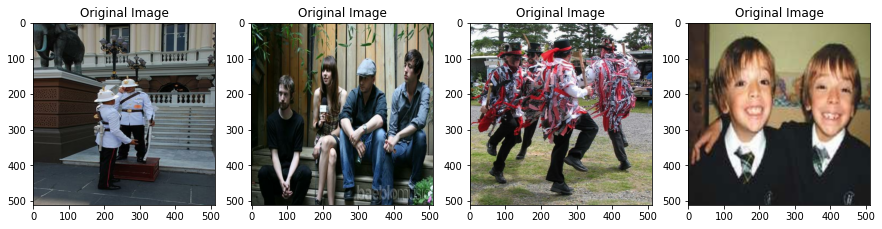

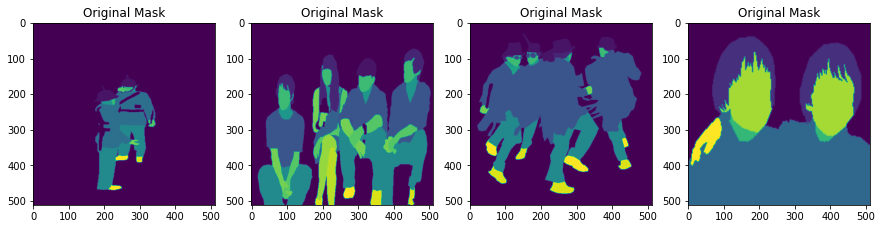

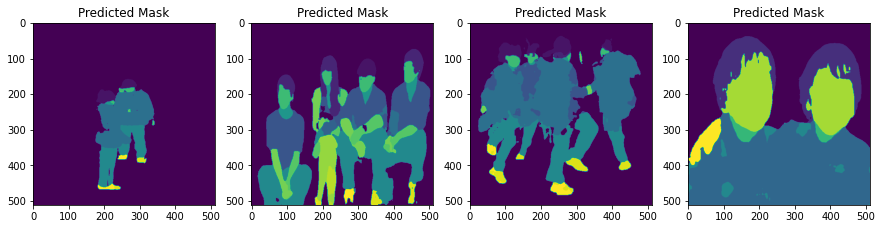

In [ ]:
model.load_weights('/content/drive/My Drive/deeplab_model 19.h5')

def inference(dataset):
 plt.figure(figsize=(15,15))
 for i in range(batch_size):
    for val in dataset.take(1):
      img = tf.cast((val[0][i]+1)*127.5,tf.uint8)
      plt.subplot(1,4,i+1)
      plt.imshow(img)
      plt.title("Original Image")
 plt.show()
 
 plt.figure(figsize=(15,15))
 for i in range(batch_size):
    for val in dataset.take(1):
      plt.subplot(1,4,i+1)
      plt.imshow(tf.squeeze(val[1][i]))
      plt.title("Original Mask")
 plt.show()
 
 plt.figure(figsize=(15,15))
 for i in range(batch_size):
    for val in dataset.take(1):
      img = val[0][i]
      plt.subplot(1,4,i+1)
      predsTrain = model.predict(np.expand_dims((img),axis=0))
      out=np.squeeze(predsTrain)
      y = np.argmax(out, axis=2)
      plt.imshow(y)
      plt.title("Predicted Mask")

plt.show()
 
inference(train_dataset)